In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.manifold import TSNE
%matplotlib inline
from __future__ import division, print_function
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
%pylab inline
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/MyDrive/PatientInfo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [ ]:
df = df[['sex', 'age', 'infection_case', 'contact_number', 'state']].dropna()
df = df[df['contact_number'].apply(lambda s: s.isnumeric() and int(s) <= 100)]

ic_id = {k: v for v, k in enumerate(df['infection_case'].unique())}
state_id = {k: v for v, k in enumerate(df['state'].unique())}

df = pd.DataFrame({
    'sex'           : df['sex'].apply(lambda sex: 0 if sex == 'male' else 1),
    'age'           : df['age'].apply(lambda age: int(age[:-1]) // 10),
    'infection_case': df['infection_case'].apply(lambda case: ic_id[case]),
    'contact_number': df['contact_number'].astype(int),
    'target'        : df['state'].apply(lambda state: state_id[state])
})

df.head()

,sex,age,infection_case,contact_number,target
0,0,5,0,75,0
1,0,3,0,31,0
2,0,5,1,17,0
3,0,2,0,9,0
4,1,2,1,2,0


(array([474.,  91.,  62.,  23.,  21.,   5.,   4.,   8.,   2.,   5.]),
 array([ 0. ,  9.5, 19. , 28.5, 38. , 47.5, 57. , 66.5, 76. , 85.5, 95. ]),
 <a list of 10 Patch objects>)

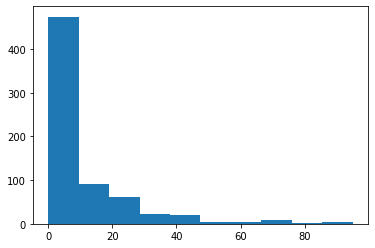

In [ ]:
plt.hist(df.contact_number)

(array([0, 1, 2]), array([457, 233,   5]))


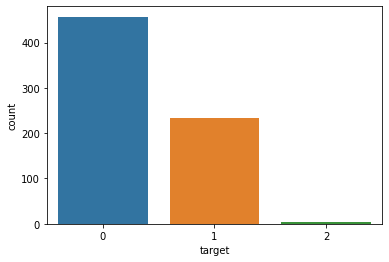

In [ ]:
print(np.unique(df.target, return_counts=True))
sns.countplot(x='target', data=df)

In [ ]:
!pip3 uninstall umap
!pip3 install umap-learn

In [ ]:
X, y = df.drop(['target'], axis = 1), df['target']

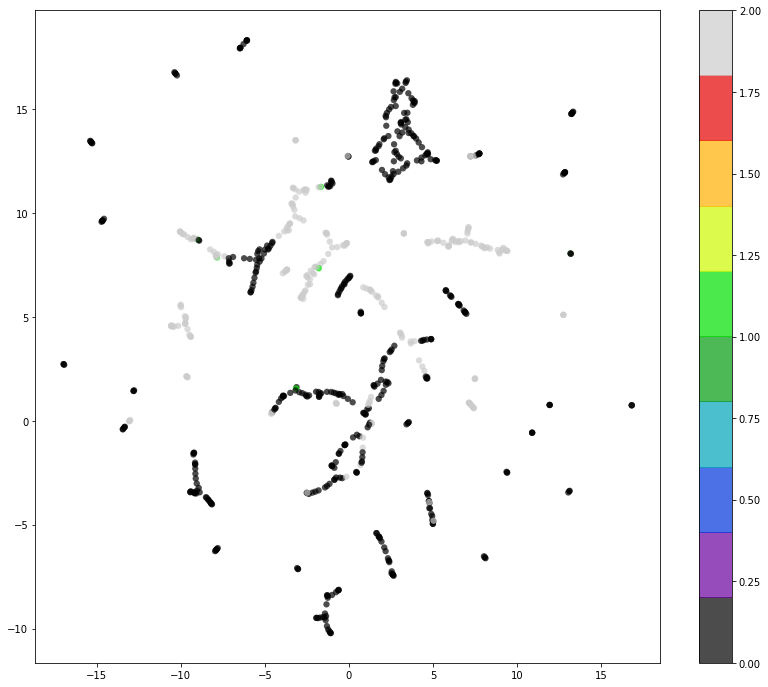

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=3, min_dist = 0.2, random_state=42)
reducer.fit(df)

X_reduced_umap = reducer.transform(df)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Meaning of the 2 components:
-0.001 x sex + -0.001 x age + 0.002 x infection_case + 1.000 x contact_number
0.005 x sex + 0.081 x age + 0.997 x infection_case + -0.002 x contact_number


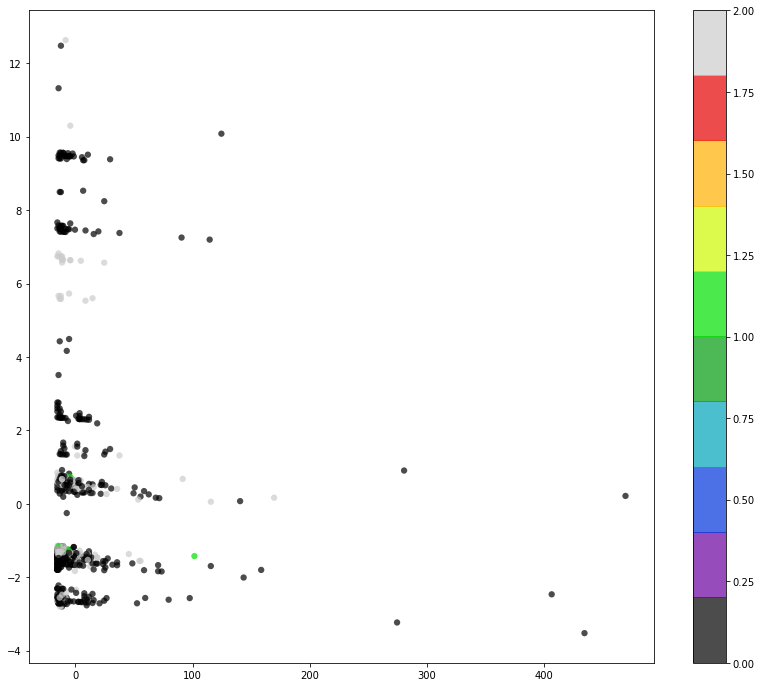

In [ ]:
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)


print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            X.columns)))

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

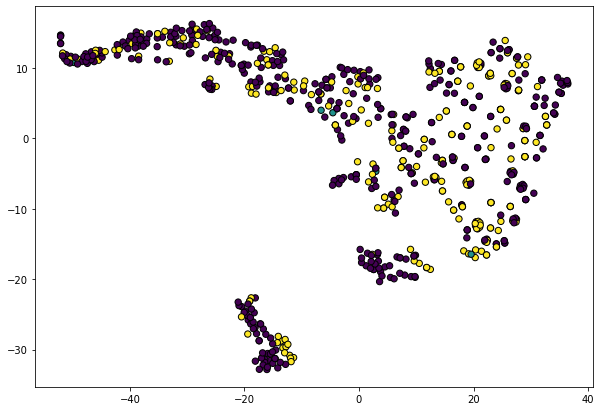

In [ ]:
tsne = TSNE(n_components=2, random_state=21)

X_reduced_tsne = tsne.fit_transform(X)


plt.figure(figsize=(10,7))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, s=40, edgecolor="k")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

clusters_n = [3, 6, 10]

def do_kmeans(X, n):
  clusters = KMeans(n_clusters=n).fit_predict(X)

  in_n, in_d, out_n, out_d = 0, 0, 0, 0
  for i in range(len(X)):
    for j in range(i + 1, len(X)):
      if (clusters[i] == clusters[j]):
        in_n += np.linalg.norm(X[i] - X[j])
        in_d += 1
      else:
        out_n += np.linalg.norm(X[i] - X[j])
        out_d += 1

  plt.figure(figsize=(8, 6))
  plt.scatter(X[:, 0], X[:, 1], c=clusters)
  plt.show()

  print("average in: ", in_n / in_d)
  print("average out: ", out_n / out_d)

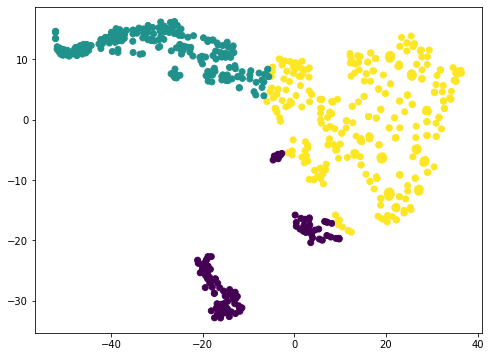

average in:  16.91848532634306
average out:  44.031736479947305


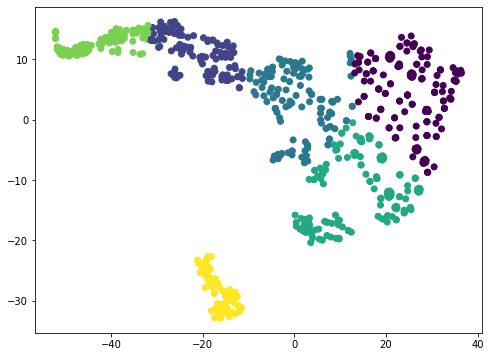

average in:  9.958950756899767
average out:  37.59922725470846


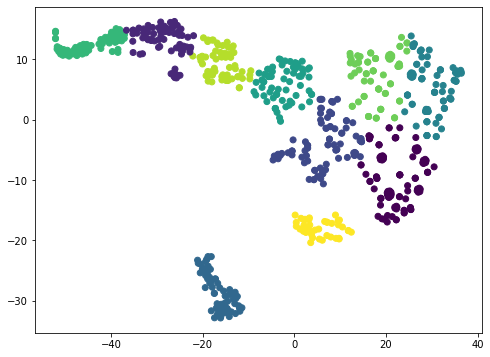

average in:  6.476972685923065
average out:  35.5419966936245


In [ ]:
for n in clusters_n:
  do_kmeans(X_reduced_tsne, n)

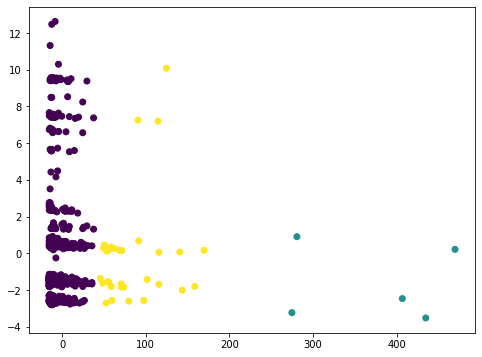

average in:  11.895556075118929
average out:  131.9359694934858


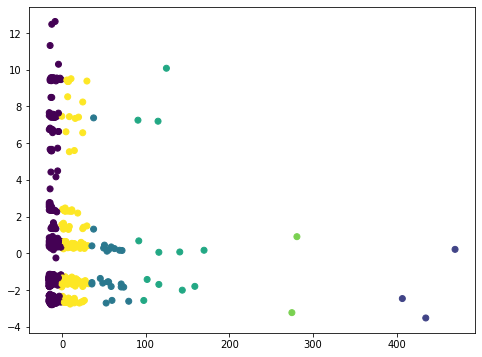

average in:  6.019646131446508
average out:  49.62059341605346


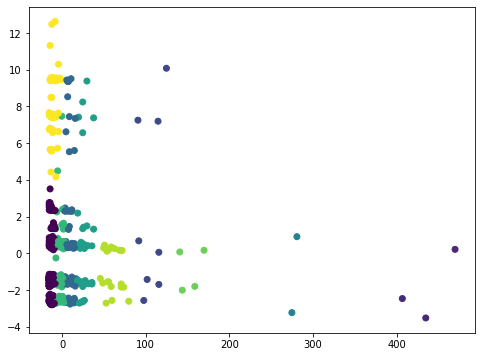

average in:  3.179505285592327
average out:  34.3822512575007


In [ ]:
for n in clusters_n:
  do_kmeans(X_reduced_pca, n)

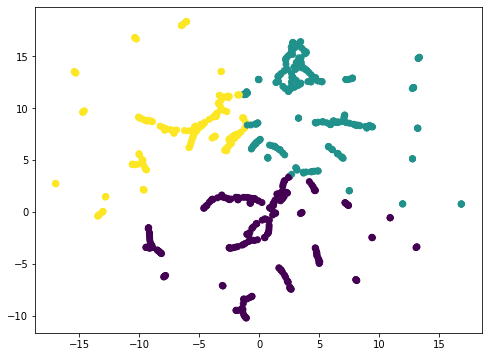

average in:  7.159387982022989
average out:  14.062548068700174


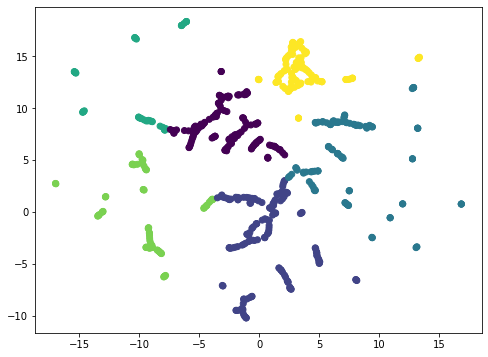

average in:  4.972230385927569
average out:  13.264233625415873


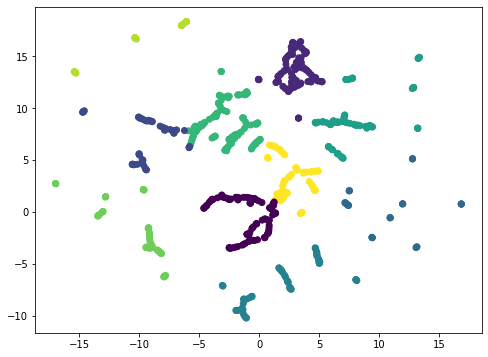

average in:  3.3621497759329366
average out:  12.830669151403482


In [ ]:
for n in clusters_n:
  do_kmeans(X_reduced_umap, n)